<a href="https://colab.research.google.com/github/Yen-Yu-Chen/wk/blob/master/Copy_of_2_%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%922_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# check GPU infomation
!nvidia-smi

Tue Apr 21 10:02:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    27W /  70W |    609MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
# check google drive mounting
import os
if not os.path.isdir('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Google drive is mounted !")

Google drive is mounted !


## 匯入所有需要的套件模組

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# tensorflow.keras
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version =", tf.__version__)
#把真正需要的模組匯入就好，可以節省記憶體空間
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import optimizers, layers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K

Tensorflow version = 2.2.0-rc3


# 準備資料集

## 1-讀取資料集

In [ ]:
# 自定義來源路徑
file = '/content/drive/My Drive/Colab Notebooks/dataset0421.csv'
df = pd.read_csv(file, index_col=0)  # 將第0欄作為 index
df

,man,woman,outside,inside,examine,TW_confirm,TPE entry,TW_new,global_new
2020-01-21,0.0,1.0,1.0,0.0,0.012,1.0,5.9421,0.00,0.000000
2020-01-22,0.0,0.0,0.0,0.0,0.044,1.0,6.5754,0.00,0.000000
2020-01-23,0.0,0.0,0.0,0.0,0.070,1.0,6.6838,0.00,0.460517
2020-01-24,1.0,1.0,2.0,0.0,0.057,3.0,5.8104,0.10,0.566296
2020-01-25,0.0,0.0,0.0,0.0,0.091,3.0,4.9115,0.00,0.620254
...,...,...,...,...,...,...,...,...,...
2020-04-17,0.0,0.0,0.0,0.0,0.844,395.0,0.0992,0.00,1.138229
2020-04-18,3.0,0.0,0.0,0.0,0.560,398.0,0.0688,0.15,1.125892
2020-04-19,20.0,2.0,21.0,0.0,0.628,420.0,0.0692,1.10,1.133405
2020-04-20,0.0,2.0,2.0,0.0,1.853,422.0,0.0480,0.10,1.116876


In [ ]:
# 不使用 'y', 'TW_confirm'
data_df = df.drop(columns='TW_confirm')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, 2020-01-21 to 2020-04-21
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   man         92 non-null     float64
 1   woman       92 non-null     float64
 2   outside     92 non-null     float64
 3   inside      92 non-null     float64
 4   examine     92 non-null     float64
 5   TPE entry   92 non-null     float64
 6   TW_new      92 non-null     float64
 7   global_new  92 non-null     float64
dtypes: float64(8)
memory usage: 6.5+ KB


In [ ]:
# 轉成 numpy array
data = data_df.values
data.shape

(92, 8)

## 2-資料前處理

### 定義資料產生器
以產生時間序列樣本 example (X) 、及其目標 target y
- data - 原始的浮點數資料陣列
- lookback - 輸入的資料應回溯多少個時間點
- delay - 目標 y 應該在未來多少個時間點
- min_index - 欲使用資料陣列的最小索引值
- max_index - 欲使用資料陣列的最大索引值
- shuffle - 是否按照時間順序使用樣本，或打亂樣本
- batch_size - 每批次的樣本數量

In [ ]:
# 定義 generator
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index  # 資料起始 index

    # 一直循環
    while True:
        # 產生 批次的rows (資料時間點)
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if (i > max_index): 
                i = min_index  # reset 資料起始 index
            rows = np.arange(i, min(i + batch_size, max_index + 1))
            i = i + len(rows)  # 下一個起點

        # 產生批次全為0的 samples 和 targets
        samples = np.zeros((len(rows), lookback, data.shape[-1]), dtype=np.float32)
        targets = np.zeros((len(rows), ), dtype=np.float32)
        # 逐筆填入資料
        for j, row in enumerate(rows):
            indexes = range(rows[j] - lookback, rows[j])
            samples[j] = data[indexes]
            try:
                targets[j] = data[rows[j] + delay][6]  # <-- [6] 為預測的特徵欄位index(台灣新增人數) (自行修改)
            except IndexError:
                # test data 會找不到對應的 y
                targets[j] = np.nan

        # 依呼叫產生一批 samples 和 targets
        yield samples, targets

### 建立 訓練資料產生器、驗證資料產生器

In [ ]:
# 定義變數
lookback = 8 #自己定義往回定義幾天，因為資料有限，所以剩下的訓練資料會變少(實際可以訓練的資料 = total_data-lookback)
delay = 7
batch_size = 3

print("可訓練資料 max_index =", len(data) - delay - 1)
print("可訓練資料筆數 :", len(data) - delay - lookback) #只抓出成對的(頭尾可能有不成對)

# 訓練資料產生器
min_index = 0 + lookback  # 第8筆開始，可使用回溯8天的資料
max_index = 76  # 前70筆作訓練用(最大不可以超過可訓練資料 max_index)
train_steps = int(np.ceil((max_index - min_index + 1)/batch_size))
print("train_steps per epoch:", train_steps)

train_gen = generator(data=data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=min_index, 
                      max_index=max_index, 
                      shuffle=True,  # 訓練是否洗牌
                      batch_size=batch_size)

# 驗證資料產生器
min_index = 77
max_index = 84  # 84-7-1 為可訓練(有X也有y)的最後一筆
valid_steps = int(np.ceil((max_index - min_index + 1)/1)) #總共需要跑幾批次
print("valid_steps per epoch:", valid_steps)

valid_gen = generator(data=data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=min_index, 
                      max_index=max_index, 
                      shuffle=False,  # 驗證不必要洗牌
                      batch_size=1) #因為比數很少，一筆一筆做也不會太慢

可訓練資料 max_index = 84
可訓練資料筆數 : 77
train_steps per epoch: 23
valid_steps per epoch: 8


In [ ]:
# 測試資料產生器(把每次印出來)
for k in range(train_steps):
    samples, targets = next(train_gen)
    print(f"batch {k} samples/targets shape :", samples.shape, targets.shape,  "targets =", targets)
for k in range(valid_steps):
    samples, targets = next(valid_gen)
    print(f"batch {k} samples/targets shape :", samples.shape, targets.shape,  "targets =", targets)
#sample.shape(batch_size, lookback, feature)

batch 0 samples/targets shape : (3, 8, 8) (3,) targets = [0.1 0.  0.1]
batch 1 samples/targets shape : (3, 8, 8) (3,) targets = [0.5  0.4  0.85]
batch 2 samples/targets shape : (3, 8, 8) (3,) targets = [0.5  0.15 0.4 ]
batch 3 samples/targets shape : (3, 8, 8) (3,) targets = [0.05 0.5  0.05]
batch 4 samples/targets shape : (3, 8, 8) (3,) targets = [0.75 0.1  1.  ]
batch 5 samples/targets shape : (3, 8, 8) (3,) targets = [0.4  1.   0.05]
batch 6 samples/targets shape : (3, 8, 8) (3,) targets = [0.   0.9  0.85]
batch 7 samples/targets shape : (3, 8, 8) (3,) targets = [0.35 0.5  0.5 ]
batch 8 samples/targets shape : (3, 8, 8) (3,) targets = [0.9  0.15 0.05]
batch 9 samples/targets shape : (3, 8, 8) (3,) targets = [0.9  0.05 0.05]
batch 10 samples/targets shape : (3, 8, 8) (3,) targets = [0.4  0.1  0.45]
batch 11 samples/targets shape : (3, 8, 8) (3,) targets = [0.   0.75 0.4 ]
batch 12 samples/targets shape : (3, 8, 8) (3,) targets = [0.1 1.3 0.5]
batch 13 samples/targets shape : (3, 8, 8

# 設計模型 modeling
https://keras.io/models/sequential/
(嘗試不同的設計)

## -模型設計1 - GRU (LSTM的簡化版本)

In [ ]:
# # 清空所有暫存
# K.clear_session()

# # build model
# model = Sequential()  # 使用序列式建模
# model.add(layers.Input((lookback, data.shape[-1])))  # (時間空間的維度, 輸入特徵空間的維度)
# model.add(layers.GRU(8, #幾個GRU
#                      dropout=0.1, #在gru神經元中，抓10%隨機遮蔽
#                      recurrent_dropout=0.0, #在時間、空間維度，做捨棄
#                      return_sequences=True)) #true代表每個時間點都會產生一個輸出(代表可以做堆疊)
# #dropout的功用是避免overfitting
# model.add(layers.GRU(9, 
#                      dropout=0.1, 
#                      recurrent_dropout=0.0, 
#                      return_sequences=True))
# model.add(layers.GRU(9, 
#                      dropout=0.1, 
#                      recurrent_dropout=0.0, 
#                      return_sequences=True))
# model.add(layers.GRU(8, 
#                      dropout=0.1, 
#                      recurrent_dropout=0.0, 
#                      return_sequences=True))
# model.add(layers.GRU(8, 
#                      dropout=0.1, 
#                      recurrent_dropout=0.0, 
#                      return_sequences=True))
# model.add(layers.GRU(8, 
#                      dropout=0.1, 
#                      recurrent_dropout=0.0)) #最後一層return_sequences=false就好，因為只要"一個"輸出
# # model.add(layers.Dense(5, activation='relu'))
# # model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1))
# model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 8, 8)              432       
_________________________________________________________________
gru_1 (GRU)                  (None, 8, 9)              513       
_________________________________________________________________
gru_2 (GRU)                  (None, 8, 9)              540       
_________________________________________________________________
gru_3 (GRU)                  (None, 8, 8)              456       
_________________________________________________________________
gru_4 (GRU)                  (None, 8, 8)              432       
_________________________________________________________________
gru_5 (GRU)                  (None, 8)                 432       
_________________________________________________________________
dense (Dense)                (None, 1)                 9

## -模型設計2 - LSTM

In [ ]:
# 清空所有暫存
K.clear_session()

# build model
model = Sequential()  # 使用序列式建模
model.add(layers.Input((lookback, data.shape[-1])))  # (時間空間的維度, 輸入特徵空間的維度)
model.add(layers.LSTM(12, 
                      dropout=0.1, 
                      recurrent_dropout=0.0, 
                      return_sequences=True))
model.add(layers.LSTM(10, 
                     dropout=0.0, 
                     recurrent_dropout=0.0))

# model.add(layers.Dense(5, activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8, 12)             1008      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                920       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 1,939
Trainable params: 1,939
Non-trainable params: 0
_________________________________________________________________


## -模型圖

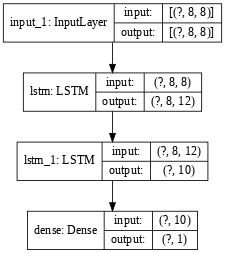

In [ ]:
# plot model
plot_model(model, to_file="model_plot_0421.png", show_shapes=True, dpi=60)

## -編譯模型
- https://keras.io/losses/
- https://keras.io/optimizers/
- https://keras.io/metrics/

In [ ]:
# compile model
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

# 訓練模型 training

## -開始訓練模型

In [ ]:
# start training
EPOCHS = 30
history = model.fit(train_gen, 
                    steps_per_epoch=train_steps*10, #每一個epoch會看過10遍data (為了讓繪圖方便)
                    epochs=EPOCHS, 
                    validation_data=valid_gen, 
                    validation_steps=valid_steps)

Epoch 1/30
230/230 [==============================] - 2s 8ms/step - loss: 0.1103 - mae: 0.2269 - val_loss: 0.2631 - val_mae: 0.5071
Epoch 2/30
230/230 [==============================] - 1s 6ms/step - loss: 0.0369 - mae: 0.1295 - val_loss: 0.2004 - val_mae: 0.4228
Epoch 3/30
230/230 [==============================] - 1s 6ms/step - loss: 0.0314 - mae: 0.1246 - val_loss: 0.1130 - val_mae: 0.2555
Epoch 4/30
230/230 [==============================] - 1s 6ms/step - loss: 0.0234 - mae: 0.1078 - val_loss: 0.1355 - val_mae: 0.3288
Epoch 5/30
230/230 [==============================] - 1s 6ms/step - loss: 0.0230 - mae: 0.1030 - val_loss: 0.1534 - val_mae: 0.3598
Epoch 6/30
230/230 [==============================] - 1s 6ms/step - loss: 0.0255 - mae: 0.1079 - val_loss: 0.1563 - val_mae: 0.3533
Epoch 7/30
230/230 [==============================] - 1s 6ms/step - loss: 0.0209 - mae: 0.0930 - val_loss: 0.1124 - val_mae: 0.2648
Epoch 8/30
230/230 [==============================] - 1s 6ms/step - loss: 0.

## -訓練曲線

In [ ]:
# The history.history attribute is a dictionary
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

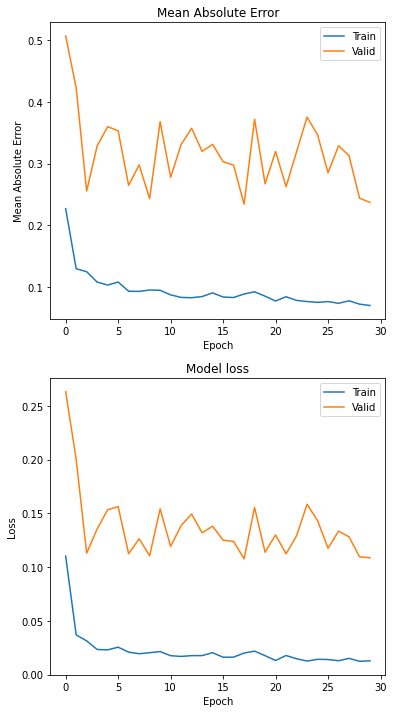

In [ ]:
# Training history visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,12))

# Plot training & validation accuracy values
ax1.plot(history.history['mae'])
ax1.plot(history.history['val_mae'])
ax1.set_title('Mean Absolute Error')
ax1.set(ylabel='Mean Absolute Error', xlabel='Epoch')
ax1.legend(['Train', 'Valid'], loc='upper right')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set(ylabel='Loss', xlabel='Epoch')
ax2.legend(['Train', 'Valid'], loc='upper right')

# plt.savefig('train_history.png', dpi=72)  # <-- save plot
plt.show()

## -儲存模型

In [ ]:
# save model
model.save("model_0421.h5")

# 模型評估 evaluation
https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

In [ ]:
y_true = np.array([ next(valid_gen)[1] for i in range(valid_steps) ])
y_pred = model.predict(valid_gen,
                       steps=valid_steps, 
                       verbose=1)
# 乘回來y特徵工程時的倍數
y_true = y_true * 20
y_pred = y_pred.reshape(-1,) * 20

print("y_true shape:", y_true.shape, "\ty_pred shape:", y_pred.shape)
print("y_pred =", y_pred)

8/8 [==============================] - 0s 2ms/step
y_true shape: (8, 1) 	y_pred shape: (8,)
y_pred = [5.5533476 5.6674986 5.7654    8.202482  2.3162265 1.5862837 2.998265
 4.338523 ]


In [ ]:
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("Median Absolute Error (MAE) =", median_absolute_error(y_true, y_pred))
print("Root Mean Square Error (RMSE) =", mean_squared_error(y_true, y_pred, squared=False))
print("R² score =", r2_score(y_true, y_pred))

Median Absolute Error (MAE) = 3.3818326
Root Mean Square Error (RMSE) = 6.5941515
R² score = 0.0893647607942526


# 模型預測 prediction

## -載入模型

In [ ]:
# restore model
model = load_model('model_0421.h5')
model.trainable = False  # freeze all layers for inference

## -下載交卷範本

In [ ]:
# 下載交卷範本
#!wget 'https://storage.googleapis.com/meso_patho/submission_sample.csv'
submit_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/submission_sample.csv')
submit_df

,Date,Confirm_cases
0,2020/4/1,0
1,2020/4/2,0
2,2020/4/3,0
3,2020/4/4,0
4,2020/4/5,0
5,2020/4/6,0
6,2020/4/7,0
7,2020/4/22,0
8,2020/4/23,0
9,2020/4/24,0


## [第一區段預測]
04/01 - 04/07

In [ ]:
# 測試資料產生器
min_index = df.index.get_loc('2020-03-25')  # 取得起始日期-7的 index (-delay)
max_index = df.index.get_loc('2020-03-31')  # 取得結束日期-7的 index (-delay)
test_steps = int(np.ceil((max_index - min_index + 1)/1))
print("test_steps per epoch:", test_steps)

test_gen = generator(data=data, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=min_index, 
                     max_index=max_index, 
                     shuffle=False,  # 依定要按時序預測
                     batch_size=1)

for k in range(test_steps):
    samples, targets = next(test_gen)
    print(f"batch {k} samples/targets shape :", samples.shape, targets.shape,  "targets =", targets)

test_steps per epoch: 7
batch 0 samples/targets shape : (1, 8, 8) (1,) targets = [0.35]
batch 1 samples/targets shape : (1, 8, 8) (1,) targets = [0.5]
batch 2 samples/targets shape : (1, 8, 8) (1,) targets = [0.45]
batch 3 samples/targets shape : (1, 8, 8) (1,) targets = [0.35]
batch 4 samples/targets shape : (1, 8, 8) (1,) targets = [0.4]
batch 5 samples/targets shape : (1, 8, 8) (1,) targets = [0.5]
batch 6 samples/targets shape : (1, 8, 8) (1,) targets = [0.15]


## --預測

In [ ]:
# prediction
y_pred_1 = model.predict(test_gen, 
                       steps=test_steps, 
                       verbose=1)
y_pred_1 = y_pred_1.reshape(-1,)  # flatten array to 1D

# 乘回來y特徵工程時的倍數
y_pred_1 = y_pred_1 * 20

print("Predicted result =", y_pred_1)

7/7 [==============================] - 0s 2ms/step
Predicted result = [7.924391  8.051063  7.083844  6.125413  4.7929087 5.6828537 1.8838933]


## --數據後處理
將每日新增人數 轉為 累計人數

In [ ]:
last_tw_confirm = df.loc['2020-03-31']['TW_confirm']  # 此時間區段的前一天累計人數
y_pred = []
for j, new in enumerate(y_pred_1):
    if (j==0):
        # 第一筆資料建立，最近一天累計+新增
        y_pred.append(last_tw_confirm + new)
    else:
        # 如果 y_pred 已有資料，最後一筆+新增
        y_pred.append(y_pred[-1] + new)
y_pred

[329.9243907928467,
 337.97545337677,
 345.0592975616455,
 351.1847105026245,
 355.9776191711426,
 361.66047286987305,
 363.5443661212921]

In [ ]:
# ground truth
df.loc['2020-04-01':'2020-04-07']['TW_confirm']

2020-04-01    329.0
2020-04-02    339.0
2020-04-03    348.0
2020-04-04    355.0
2020-04-05    363.0
2020-04-06    373.0
2020-04-07    376.0
Name: TW_confirm, dtype: float64

## [第二區段預測]
04/22 - 04/28

In [ ]:
# 測試資料產生器
min_index = df.index.get_loc('2020-04-15')  # 取得起始日期-7的 index (-delay)
max_index = df.index.get_loc('2020-04-21')  # 取得結束日期-7的 index (-delay)
test_steps = int(np.ceil((max_index - min_index + 1)/1))
print("test_steps per epoch:", test_steps)

test_gen = generator(data=data, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=min_index, 
                     max_index=max_index, 
                     shuffle=False,  # 依定要按時序預測
                     batch_size=1)

for k in range(test_steps):
    samples, targets = next(test_gen)
    print(f"batch {k} samples/targets shape :", samples.shape, targets.shape,  "targets =", targets)

test_steps per epoch: 7
batch 0 samples/targets shape : (1, 8, 8) (1,) targets = [nan]
batch 1 samples/targets shape : (1, 8, 8) (1,) targets = [nan]
batch 2 samples/targets shape : (1, 8, 8) (1,) targets = [nan]
batch 3 samples/targets shape : (1, 8, 8) (1,) targets = [nan]
batch 4 samples/targets shape : (1, 8, 8) (1,) targets = [nan]
batch 5 samples/targets shape : (1, 8, 8) (1,) targets = [nan]
batch 6 samples/targets shape : (1, 8, 8) (1,) targets = [nan]


## --預測

In [ ]:
# prediction
y_pred_2 = model.predict(test_gen, 
                       steps=test_steps, 
                       verbose=1)
y_pred_2 = y_pred_2.reshape(-1,)  # flatten array to 1D

# 乘回來y特徵工程時的倍數
y_pred_2 = y_pred_2 * 20

print("Predicted result =", y_pred_2)

7/7 [==============================] - 0s 2ms/step
Predicted result = [12.723108 14.20318  12.907434 11.699094 12.753697 15.478199  9.967594]


## --數據後處理
將每日新增人數 轉為 累計人數

In [ ]:
last_tw_confirm = df.loc['2020-04-21']['TW_confirm']  # 此時間區段的前一天累計人數

for j, new in enumerate(y_pred_2):
    if (j==0):
        # 第一筆資料建立，最近一天累計+新增
        y_pred.append(last_tw_confirm + new)
    else:
        # 如果 y_pred 已有資料，最後一筆+新增
        y_pred.append(y_pred[-1] + new)
y_pred

[329.9243907928467,
 337.97545337677,
 345.0592975616455,
 351.1847105026245,
 355.9776191711426,
 361.66047286987305,
 363.5443661212921,
 437.723108291626,
 451.9262886047363,
 464.8337230682373,
 476.53281688690186,
 489.28651428222656,
 504.7647132873535,
 514.732307434082]

# 提交答案 submission

## -填入答案

In [ ]:
submit_df['Confirm_cases'] = y_pred
submit_df

,Date,Confirm_cases
0,2020/4/1,329.924391
1,2020/4/2,337.975453
2,2020/4/3,345.059298
3,2020/4/4,351.184711
4,2020/4/5,355.977619
5,2020/4/6,361.660473
6,2020/4/7,363.544366
7,2020/4/22,437.723108
8,2020/4/23,451.926289
9,2020/4/24,464.833723


## -另存檔案

In [ ]:
# save without index column
submit_df.to_csv('my_submission0422-28.csv', index=False)

## -下載提交檔

In [ ]:
from google.colab import files
files.download('my_submission0422-28.csv')